### Libraries:

In [29]:
%load_ext rpy2.ipython
%R library(dplyr); library(ggplot2); library(gridExtra); library(vegan)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: This is vegan 2.3-4

  res = super(Function, self).__call__(*new_args, **new_kwargs)


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['vegan', 'lattice', 'permute', 'gridExtra', 'ggplot2', 'dplyr',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'], 
      dtype='|S9')

### Functions:

In [6]:
%%R

combine_smr_tables <- function(tablelist){
    all<-data.frame()
    for (t in tables){
        df = read.table(t, sep="\t", header=TRUE)
        all <- rbind(all, df) 
        }
    return(all)
    }

In [7]:
%%R
# returns a table with a row per metagenome and the following columns:
# reads_per_mbp: number of metagenomic reads recruited per mpb
# prop_mgreads_per_mbp: proportion total meteganome reads recruited per total_sag_mbp
# pct_metagenome: percent metagenomic reads recruited to all sags** this value will be the bar plot 
# underneath the y-axis of the heatmap

summarise_mgs <- function(df){
    mg_summary <- df %>% filter(sag == "concatenated_sags") %>% .[,c(1:8)]
    total_sag_bp <- all %>% .[,c(1,10)] %>% unique %>% filter(sag != "concatenated_sags") %>% .[,2] %>% sum 
    mg_summary$total_sag_bp <- total_sag_bp
    mg_summary$sag_size_mbp <- total_sag_bp/1000000
    mg_summary <- mg_summary %>% mutate(reads_per_mbp=total_reads_recruited/sag_size_mbp, 
                                        prop_mgreads_per_mbp=(total_reads_recruited/sag_size_mbp)/mg_read_count,
                                       pct_metagenome=(total_reads_recruited/mg_read_count)*100)
    underplot <- mg_summary[,c(2,ncol(mg_summary))]
    return(underplot)
}



In [8]:
%%R
# summarise the number of total mg reads recruited to each SAG
# for the side plot of the heatmap

summarise_sags <- function(pairs){
    total_mg_reads <- pairs[,8] %>% unique %>% sum
    sideplot <- pairs %>% group_by(sag) %>% summarise(pct_reads_recruited_allmgs = (sum(total_reads_recruited)/total_mg_reads)*100)
    return(sideplot)
}

In [43]:
%%R
# Plot fuctions 

main_heatmap <- function(pairs, lowcolor="white",midcolor="lightblue", highcolor="darkblue"){

    p1 <- pairs %>% ggplot(aes(metagenome, sag)) + geom_tile(aes(fill=prop_mgreads_per_mbp)) + theme_bw() 
    pmain <- p1 + theme(axis.ticks = element_blank(), axis.title.x=element_blank(), axis.text.x=element_blank())
    pmain <- pmain + labs(x=" ", fill="") + scale_fill_gradientn(colours=c(lowcolor,midcolor,highcolor), values=c(0,0.00001,1))
    pmain <- pmain  + theme(legend.key.height=unit(50, "pt"), legend.position="none") 
    pmain <- pmain + theme(panel.border = element_blank(), 
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(), 
                           panel.background = element_blank()) 
    return(pmain)
}

# plot legend for heatmap separately from the heatmap itself: 
hm_legend <- function(pairs, lowcolor="white",midcolor="lightblue", highcolor="darkblue"){
    
    legend <- pairs %>% ggplot(aes(metagenome, sag)) + geom_blank(aes(fill=prop_mgreads_per_mbp))
    legend <- legend + theme(axis.text = element_blank(),
                    axis.title = element_blank(),
                    line = element_blank(),
                    panel.background = element_blank()) + labs(fill="")
    legend <- legend + theme(legend.key.width=unit(80, "pt"), 
                             legend.position=c(.5, .5), 
                     legend.direction="horizontal") 
    legend <- legend + scale_fill_gradientn(colours=c(lowcolor,midcolor,highcolor), values=c(0,0.00001,1))
    return(legend)

}

mg_plot <- function(df, mgorder="None"){
    underplot <- summarise_mgs(df)
    if (mgorder != "None"){
        underplot$metagenome <- with(underplot, factor(metagenome, levels=mgorder[,1]))
    }
    u <- underplot %>% ggplot(aes(metagenome, pct_metagenome)) + geom_bar(stat="identity", fill="white", color="black") +  scale_y_reverse()
    u <- u + theme(axis.line.y = element_line(color="black"))+ scale_x_discrete() 
    punder <- u + labs(y="", x="") + theme(axis.text.x  = element_text(angle=90, face="bold"))
    punder <- punder + theme(panel.border = element_blank(), 
                             panel.grid.major = element_blank(),
                             panel.grid.minor = element_blank(), 
                             panel.background = element_blank(), 
                             axis.ticks = element_blank(),
                             axis.line.y = element_line(color="black")) 
    return(punder)
    }

sag_plot <- function(df, sagorder="None"){
    sideplot <- summarise_sags(df)
    if (sagorder != "None"){
        sideplot$sag <- with(sideplot, factor(sag, levels=sagorder[,1]))
    }
    s <- sideplot %>% ggplot(aes(sag, pct_reads_recruited_allmgs)) + geom_bar(stat="identity", fill="white", color="black") +  theme_classic()+ coord_flip()
    pside <- s + theme(axis.ticks = element_blank(), axis.text.y = element_blank(), axis.title = element_blank())
    pside <- pside + theme(axis.text.x = element_text(angle = -90))
    pside <- pside + theme(panel.border = element_blank(), 
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(), 
                           panel.background = element_blank(),
                           axis.line.x = element_line(color="black")) 
    return(pside)

}

# empty plot required for creating the plot array
empty_plot <- function(df){
    pempty <-ggplot(df, aes(sag, metagenome)) + geom_blank() + theme(axis.text = element_blank(),
                axis.title = element_blank(),
                line = element_blank(),
                panel.background = element_blank())
    return(pempty)
}

In [47]:
%%R
create_adjtbl <- function(edgelist){
    yaxis = unique(edgelist[,2])
    together <- data.frame(unique(edgelist[,1]))
    colnames(together)[1] <- colnames(edgelist)[1]
    for (m in seq(1,length(yaxis))){
        es <- edgelist %>% filter(.[,2]==yaxis[m])
        colnames(es)[3] <- as.character(yaxis[m])
        to_combine <- es[,c(1,3)]
        together = merge(together, to_combine, by=colnames(es)[1])
    }
    return(together)
    }

clust_order_x <- function(edgelist){
    adj <- create_adjtbl(edgelist)
    rownames(adj) <- adj[,1]
    adj[,1] <- NULL
    mat1 <- as.matrix(adj)
    xdist <- mat1 %>% vegdist(method="bray") 
    xdist[is.na(xdist)] <- 1
    xdist %>% hclust -> xclust
    xdend <- as.dendrogram(xclust)
    xorder <- order.dendrogram(xdend)
    data <- mat1[xorder,]
    levels <- seq(1, nrow(data))
    xorder <- cbind.data.frame(rownames(data), levels)
    colnames(xorder)[1] <- colnames(edgelist)[1]
    return(xorder)
    }

In [50]:
%%R

plot_array <- function(df,
                       hm_aln = 28,
                       mg_ax_aln = 105,
                       lowcolor="white",
                       midcolor="lightblue", 
                       highcolor="darkblue",
                       hclust_sags = TRUE,
                       hclust_mgs = TRUE){
    mgplot <- mg_plot(df)
    
    pairs <- df %>% filter(sag != "concatenated_sags")
    if (hclust_sags==TRUE){
        sagorder = clust_order_x(pairs[,c(1,2,13)])
        sagplot <- sag_plot(pairs, sagorder=sagorder)
        pairs$sag <- with(pairs, factor(sag, levels=sagorder[,1]))
    } else {
        sagplot <- sag_plot(pairs)
    }
    
    if (hclust_mgs==TRUE){
        mgorder = clust_order_x(pairs[,c(2,1,13)])
        mgplot <- mg_plot(df, mgorder=mgorder)
        pairs$metagenome <- with(pairs, factor(metagenome, levels=mgorder[,1]))
    } else{
        mgplot <- mg_plot(df)
    }
    
    heatmap <- main_heatmap(pairs)
    empty <- empty_plot(df)
    legend <- hm_legend(pairs)
    heatmap <- heatmap + theme(plot.margin=unit(c(0,0,hm_aln,0), "pt"))
    mgplot <- mgplot + theme(plot.margin=unit(c(-hm_aln,0,0,mg_ax_aln),"pt"))
    sagplot <- sagplot + theme(plot.margin=unit(c(0,0,0,0), "pt")) #+ theme(plot.margin=unit(c(0,0,-25,0), "pt"))
    empty <- empty + theme(plot.margin=unit(c(50,0,0,0), "pt"))
    legend <- legend + theme(plot.margin=unit(c(0,0,0,mg_ax_aln), "pt"))
    
    final <- grid.arrange(heatmap, sagplot, mgplot, empty, legend, empty,
             ncol = 2, nrow = 3, widths = c(6, 1), heights = c(8, 3, 1))
    return(final)
    
    }

### Provide a list of tables to combine, and you're good to go.

TableGrob (3 x 2) "arrange": 6 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]
5 5 (3-3,1-1) arrange gtable[layout]
6 6 (3-3,2-2) arrange gtable[layout]


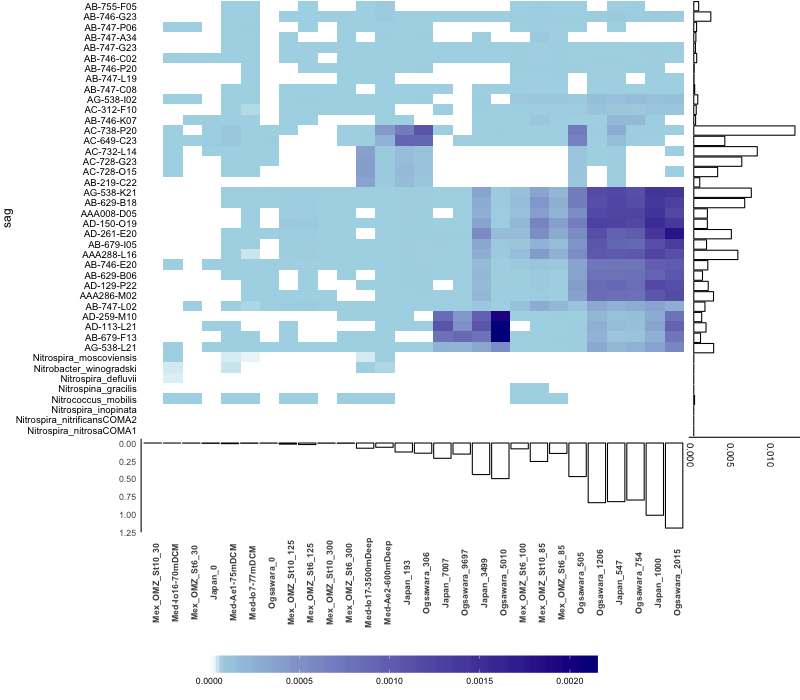

In [53]:
%%R -w 800 -h 700

tables = c("../data/Maria_smr_tables/Med_summary_table_pctid95_minlen100_overlap95.txt",
           "../data/Maria_smr_tables/Mex_OMZ_summary_table_pctid95_minlen100_overlap95.txt",
           "../data/Maria_smr_tables/Takuro_V3)summary_table_pctid95_minlen100_overlap95.txt")

all <- combine_smr_tables(tables)
plot_array(all, hclust_sags=TRUE, hclust_mgs=TRUE)